In [ ]:
#download face_recognition
%matplotlib inline
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 26 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=95569024b158e260c426bf1e5282b56c450925572119a06dda388c9161514700
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
# import library
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.cbook as cbook
import matplotlib.image as image
import matplotlib.pyplot as plt
import os
import re
import argparse
import math
import time
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy.random as npr
from PIL import Image
from numpy import asarray
from torchvision.io import read_image
import face_recognition

In [ ]:
#download Ganimation project, note for it running in colab, I modified something in the origional code
#you may not be able to run it locally with those download file. 
!gdown --id '1Y-1r9uY8ciTUlj6-mUkn2MeKVoeMskts'

Downloading...
From: https://drive.google.com/uc?id=1Y-1r9uY8ciTUlj6-mUkn2MeKVoeMskts
To: /content/ganimation_replicate.zip
100% 2.10G/2.10G [00:13<00:00, 157MB/s]


In [ ]:
#unzip the project 
from google.colab import files
import zipfile
zip_ref = zipfile.ZipFile('/content/ganimation_replicate.zip', 'r') 
zip_ref.extractall('/content') 
zip_ref.close()

In [ ]:
##load generation model
import os
os.chdir("/content/ganimation_replicate/model")
from base_model import BaseModel
from ganimation import GANimationModel

In [ ]:
# define namespace to call the pretrained generator 
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
opt= Namespace(aus_nc=17, aus_pkl='aus_openface.pkl', batch_size=10, beta1=0.5, ckpt_dir='ckpts/celebA/ganimation/190327_161852/', data_root='datasets/celebA', epoch_count=1, final_size=128, gan_type='wgan-gp', gpu_ids=[], img_nc=3, imgs_dir='imgs', init_gain=0.02, init_type='normal', interpolate_len=5, lambda_aus=160.0, lambda_dis=1.0, lambda_mask=0, lambda_rec=10.0, lambda_tv=0, lambda_wgan_gp=10.0, load_epoch=30, load_size=148, log_file='logs.txt', lr=0.0001, lr_decay_iters=50, lr_policy='lambda', lucky_seed=1637713293, max_dataset_size=150, mode='test', model='ganimation', n_threads=6, name='211123_192133', ndf=64, ngf=64, niter=20, niter_decay=10, no_aus_noise=False, no_flip=False, no_test_eval=False, norm='instance', opt_file='opt.txt', plot_losses_freq=20000, print_losses_freq=100, resize_or_crop='none', results='results/celebA_ganimation_30', sample_img_freq=2000, save_epoch_freq=2, save_test_gif=False, serial_batches=False, test_csv='test_ids.csv', train_csv='train_ids.csv', train_gen_iter=5, use_dropout=False, visdom_display_id=0, visdom_env='main', visdom_port=8097)


In [ ]:
import torch
model_path = '/content/ganimation_replicate/ckpts/celebA/ganimation/190327_161852/30_net_gen.pth'
state = torch.load(model_path)

In [ ]:
#load model 
os.chdir("/content/ganimation_replicate")
net=  GANimationModel()
net.initialize(opt)
net = getattr(net, 'net_'+'gen')
net.load_state_dict(state)

initialize network with normal
[Info] Successfully load trained weights for net_gen.


<All keys matched successfully>

In [ ]:
#load AUs features from file
import pickle
import matplotlib.pyplot as plt
import numpy as np
saved_dict = {}
with open('/content/ganimation_replicate/datasets/celebA/aus_openface.pkl', 'rb') as f:
  saved_dict = pickle.load(f, encoding='latin1')


In [ ]:
#define function to transform image to ternsor as generator required.
import torch
import os
from PIL import Image
import random
import numpy as np
import pickle
import torchvision.transforms as transforms

transform_list = []
transform_list.append(transforms.Lambda(lambda image: image))
transform_list.append(transforms.ToTensor())
transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
img2tensor = transforms.Compose(transform_list)

In [ ]:
#define function convert tensor to image, change n1,n2 to modify the ouput size of image
def tensor2im(input_image,n1,n2,imtype=np.uint8):
    if isinstance(input_image, torch.Tensor):
        image_tensor = input_image.data
    else:
        return input_image
    image_numpy = image_tensor[0].cpu().float().numpy()
    im = numpy2im(image_numpy, imtype).resize((n1, n2), Image.ANTIALIAS)
    return np.array(im)

In [ ]:
#define function convert numpy to image
def numpy2im(image_numpy, imtype=np.uint8):
      if image_numpy.shape[0] == 1:
          image_numpy = np.tile(image_numpy, (3, 1, 1))  
      image_numpy = (np.transpose(image_numpy, (1, 2, 0)) / 2. + 0.5) * 255.0
      image_numpy = image_numpy.astype(imtype)
      im = Image.fromarray(image_numpy)
      return im 

In [ ]:
#define function to generate a smile image
def changeface(image_array):
  pic = Image.fromarray(image_array)
  pic = pic.resize((128, 128), Image.ANTIALIAS)
  tar = img2tensor(pic)
  l = torch.tensor(saved_dict['000002']/5,dtype=torch.float)[None, ...]
  color_mask ,aus_mask, embed= net(tar[None,...],l)
  fake_img = aus_mask*tar + (1 - aus_mask) * color_mask
  fake_img = tensor2im(fake_img, image_array.shape[0],image_array.shape[1],imtype=np.uint8)
  return fake_img

In [ ]:
#download the trainset
!gdown --id '1ffxhI-fw7JicI5meRjnLfOwywe4dv8UN'

Downloading...
From: https://drive.google.com/uc?id=1ffxhI-fw7JicI5meRjnLfOwywe4dv8UN
To: /content/ganimation_replicate/train_set.tar
100% 3.78G/3.78G [00:26<00:00, 142MB/s]


In [ ]:
#unzip it
import tarfile
import os
zip_ref = tarfile.TarFile('/content/ganimation_replicate/train_set.tar', 'r') 
zip_ref.extractall('/content') 
zip_ref.close()

In [ ]:
#load data from dataset, return a tensor of loaded data and an array of loaded data for further usage. 
# s is the number of data you want for training. 
def load_images_from_folder(folder,s,cnn = False):
    images = []
    imagefolder = folder+'/images'
    k = os.listdir(imagefolder)[:s]
    for filename in k:
        img = plt.imread(os.path.join(folder+'/images',filename))
        if img is not None:
            images.append(img)
    labels = []
    for filename in k:
        number = int(re.search(r'\d+',  filename)[0])
        label = np.load(folder+'/annotations/'+str(number)+'_exp.npy')
        labels.append(int(label))
    images1 = np.array(images)
    labels1 = np.array(labels)
    images =torch.tensor(images1)/255
    labels =torch.tensor(labels1)
    if cnn:
      images = np.transpose(torch.tensor(images),[0,3,2,1])
      trainfeature= alexnet.features(images/255)
      data = zip(trainfeature, labels)
      data2 = []
    else:
      images = np.transpose(images,[0,3,2,1])
      data = (images, labels)
      data2 = (images1, labels1)
    return data,data2

In [ ]:
#a function to produce a tuple 
def merge(list1, list2):
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

In [ ]:
#load 2000 image due to ram restriction
traindata1,traindata2= load_images_from_folder('/content/train_set',2000,cnn = False)

In [ ]:
#define label by puting the array dataset into changeface, produce 2000 corresponding smile images. 
label = []
for img in traindata2[0]:
  label.append(changeface(img))


In [ ]:
#convert it into tensor 
label = [torch.tensor(img) for img in label]

In [ ]:
#define the data for training 
traindata =merge(traindata1[0], label)

In [ ]:
#function for training
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    model.cuda()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=5e-6)
    train_loader = torch.utils.data.DataLoader(traindata, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, label = data
            img = img.cuda()
            label = np.transpose(label,[0,3,2,1]).cuda()
            recon = model(img)
            loss = criterion(recon, label.float()/255)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [ ]:
#define autoencoder. 
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 7)
        
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
  
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

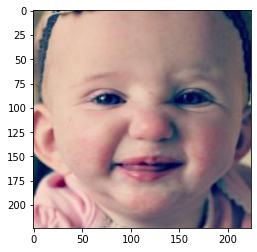

In [ ]:
#a show case of input image
plt.imshow(np.transpose(traindata[4][0],[2,1,0]))

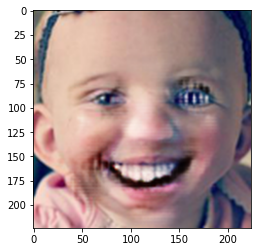

In [ ]:
#a show case of input image's label
plt.imshow(traindata[4][1])

In [ ]:
#train the model 
model = Autoencoder()
max_epochs = 160
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0667
Epoch:2, Loss:0.0646
Epoch:3, Loss:0.0632
Epoch:4, Loss:0.0766
Epoch:5, Loss:0.0408
Epoch:6, Loss:0.0434
Epoch:7, Loss:0.0328
Epoch:8, Loss:0.0287
Epoch:9, Loss:0.0248
Epoch:10, Loss:0.0273
Epoch:11, Loss:0.0269
Epoch:12, Loss:0.0214
Epoch:13, Loss:0.0227
Epoch:14, Loss:0.0235
Epoch:15, Loss:0.0217
Epoch:16, Loss:0.0208
Epoch:17, Loss:0.0164
Epoch:18, Loss:0.0206
Epoch:19, Loss:0.0173
Epoch:20, Loss:0.0151
Epoch:21, Loss:0.0176
Epoch:22, Loss:0.0197
Epoch:23, Loss:0.0182
Epoch:24, Loss:0.0168
Epoch:25, Loss:0.0187
Epoch:26, Loss:0.0159
Epoch:27, Loss:0.0167
Epoch:28, Loss:0.0148
Epoch:29, Loss:0.0179
Epoch:30, Loss:0.0144
Epoch:31, Loss:0.0160
Epoch:32, Loss:0.0150
Epoch:33, Loss:0.0139
Epoch:34, Loss:0.0130
Epoch:35, Loss:0.0159
Epoch:36, Loss:0.0141
Epoch:37, Loss:0.0174
Epoch:38, Loss:0.0161
Epoch:39, Loss:0.0149
Epoch:40, Loss:0.0188
Epoch:41, Loss:0.0127
Epoch:42, Loss:0.0124
Epoch:43, Loss:0.0141
Epoch:44, Loss:0.0150
Epoch:45, Loss:0.0131
Epoch:46, Loss:0.01

In [ ]:
#run the following if cuda is full
import torch, gc
gc.collect()
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


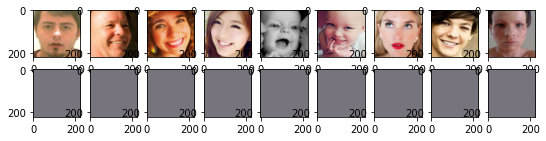

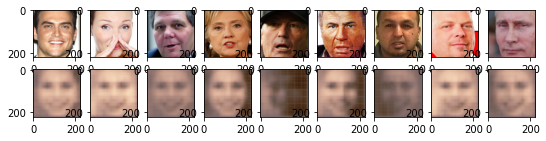

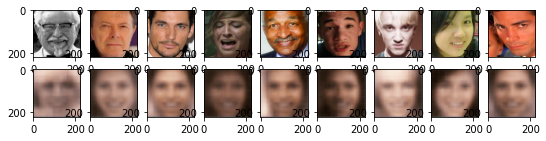

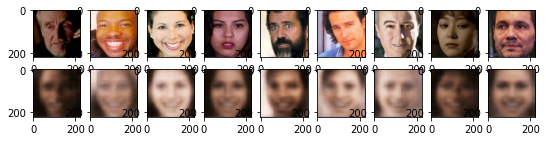

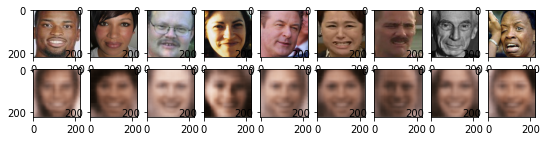

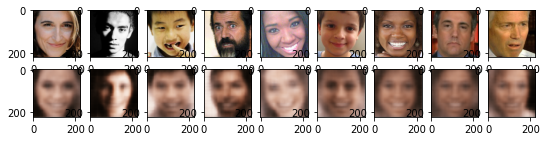

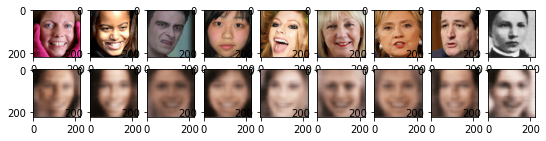

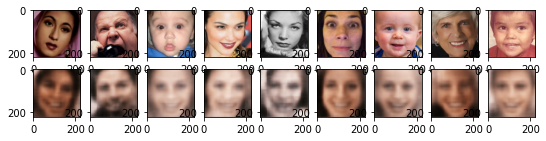

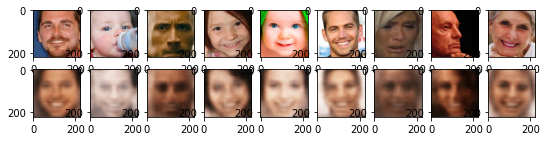

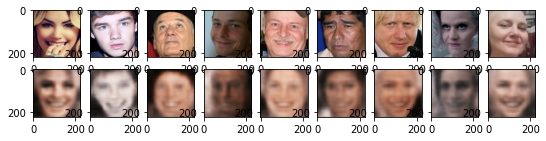

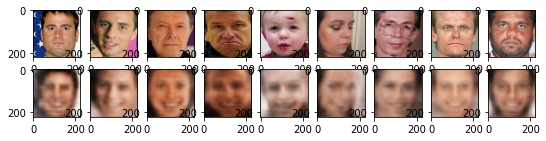

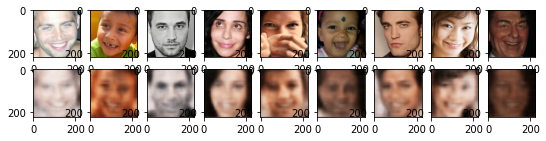

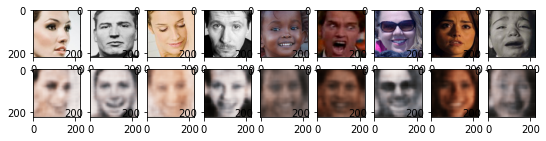

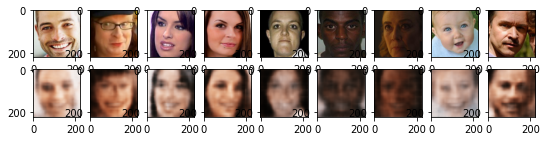

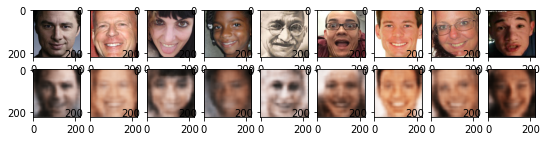

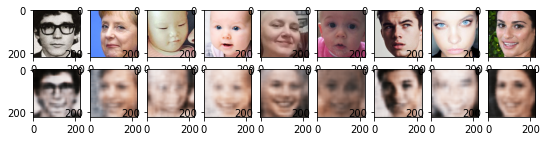

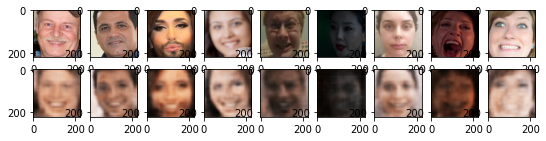

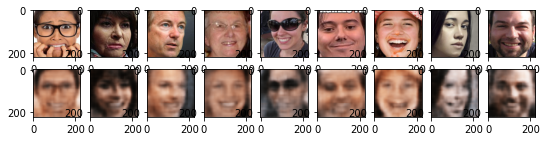

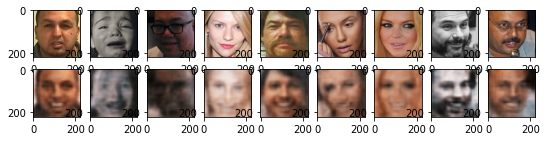

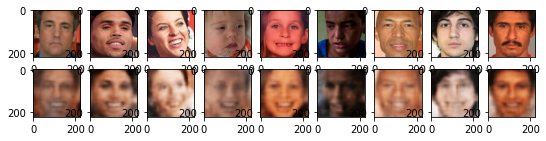

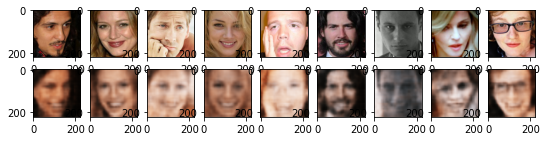

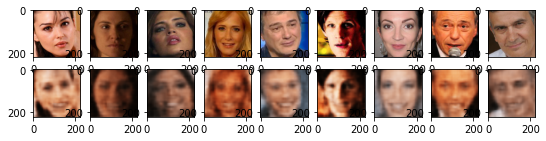

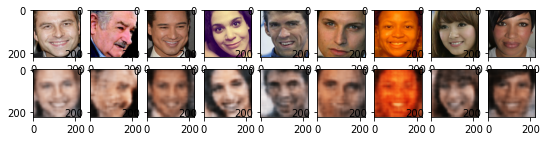

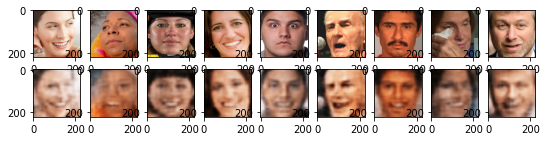

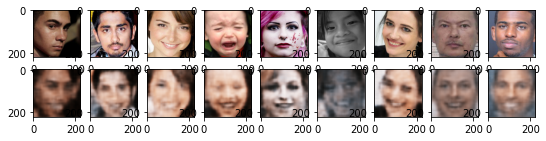

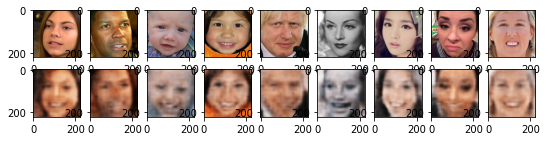

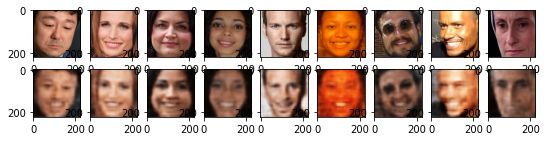

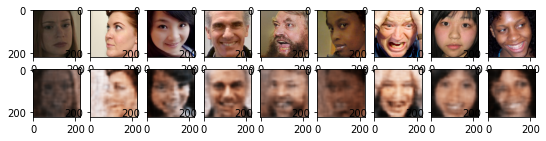

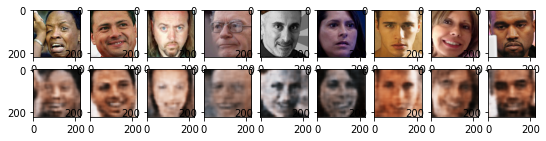

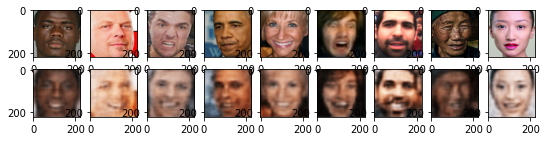

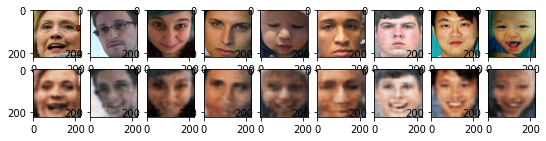

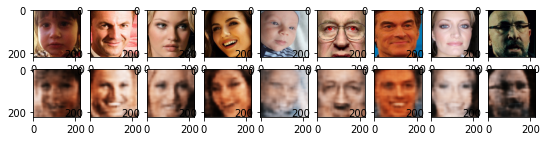

In [ ]:
#show the result 
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(np.transpose(item,[2,1,0]))
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(np.transpose(item,[2,1,0]))

To test the result, I directly used a group photo to see the result. 

In [ ]:
#download cnn model for test purpose. 
!gdown --id '1wn9D-aJDGtboO8eZFZHlxW4KS5njz_3j'

Downloading...
From: https://drive.google.com/uc?id=1wn9D-aJDGtboO8eZFZHlxW4KS5njz_3j
To: /content/ganimation_replicate/model_HFC_alex_bs512_lr0.005_epoch8
100% 39.9M/39.9M [00:00<00:00, 151MB/s] 


In [ ]:
# define model
class HappyFaceClassifier_alex(nn.Module):
    def __init__(self):
        super(HappyFaceClassifier_alex, self).__init__()
        self.name = "HFC_alex"
        self.fc1 = nn.Linear(256*6*6, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = x.view(-1, 256*6*6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
# extract human faces in an image as ROI using existing library
def Face_Extraction(image_path):
    # read the input image
    image = face_recognition.load_image_file(image_path)

    # find face locations
    face_locations = face_recognition.face_locations(image)
    
    # save extracted face image in dictionary 
    # {face_num: face_image_array}
    face_num = 1
    face_dict = {}
    for (top, right, bottom, left) in face_locations:
        face_dict[face_num] = (image[top:bottom, left:right], (top, right, bottom, left))
        print(image[top:bottom, left:right].shape)
        face_num += 1
    
    return face_dict

In [ ]:
#function to classify happy or not
def Face_Classifier(image_array):
    # define image
    image = torch.tensor(np.transpose(image_array, (2, 1, 0)))
    # resize image to fit model (3x224x224)
    transform = transforms.Compose([transforms.Resize(224),
                                    transforms.Grayscale(3)])
    image = transform(image).unsqueeze(dim=0)
    
    # define trained models
    model = HappyFaceClassifier_alex()
    pretrained_model = torchvision.models.alexnet(pretrained=True)
   
    model_path = '/content/ganimation_replicate/model_HFC_alex_bs512_lr0.005_epoch8'
    state = torch.load(model_path)
    model.load_state_dict(state)
    
    # feature extraction
    features = pretrained_model.features(image/255)
    # model prediction
    output = model(features)
    pred = (output > 0.0).squeeze().long()
    if pred == 1:
        print("This person is happy.")
        return True
    else:
        print("This person is not happy.")
        return False

In [ ]:

def Happy_Face_Recognition(image_path):
    # display image
    image_input = Image.open(image_path)
    plt.imshow(np.asarray(image_input))
    plt.show()
    
    # extract faces in the image
    face_dict = Face_Extraction(image_path)

    nonhappy_face_dict = {}
    # loop over extracted faces
    for face_num in face_dict:
        face_image_array = face_dict[face_num][0]
        
        # show extracted faces
        plt.imshow(face_image_array)
        plt.show()
        
        # recognize happy facial expression
        if Face_Classifier(face_image_array) == False:
            nonhappy_face_dict[face_num] = (face_image_array, face_dict[face_num][1])
            
    return nonhappy_face_dict

In [ ]:
#generate a new face using current autoencoder model
def Transfer_Face(nonhappy_face_dict):
    fake_face_dict = {}
    for face_num in nonhappy_face_dict:
        face_image_array = nonhappy_face_dict[face_num][0]
        pic = Image.fromarray(face_image_array)
        pic = pic.resize((224, 224), Image.ANTIALIAS)
        pic.save('my1.jpg')
        face_image_array2= plt.imread('my1.jpg') 
        fake_image_array = np.transpose(np.asarray(model(torch.tensor(np.transpose(face_image_array2,[2,1,0])/255)[None,...].float().cuda()).cpu().detach()),[0,3,2,1])
        fake_image_array=fake_image_array[0]* 255
        fake_image_array= fake_image_array.astype(np.uint8)
        pic = Image.fromarray(fake_image_array)
        pic = pic.resize((face_image_array.shape[1], face_image_array.shape[0]), Image.ANTIALIAS)
        pic.save('my.jpg')
        fake_image_array= plt.imread('my.jpg')                                                                                 
        fake_face_dict[face_num] = (fake_image_array, nonhappy_face_dict[face_num][1])
        
    return fake_face_dict

In [ ]:
#puting the new face back into original image
def Replace_Face(fake_face_dict, image_path):
    # read the input image
    image = face_recognition.load_image_file(image_path)
    
    for face_num in fake_face_dict:
        face_image_array = fake_face_dict[face_num][0]
        
        # replace face images
        (top, right, bottom, left) = fake_face_dict[face_num][1]
        image[top:bottom, left:right] = face_image_array

    plt.imshow(image)
    plt.show()
    return Image.fromarray(image)

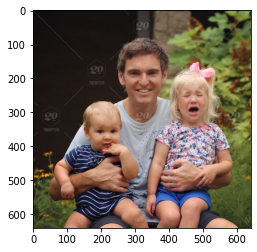

(129, 129, 3)
(89, 90, 3)
(90, 90, 3)


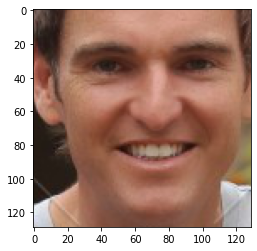

This person is happy.


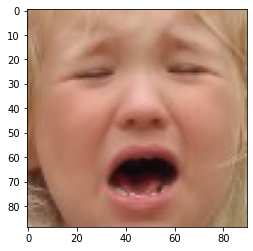

This person is not happy.


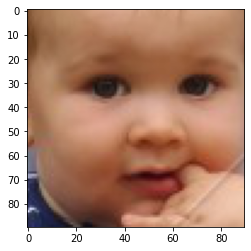

This person is not happy.
(224, 224, 3)
(224, 224, 3)


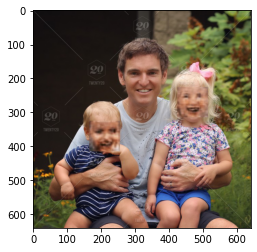

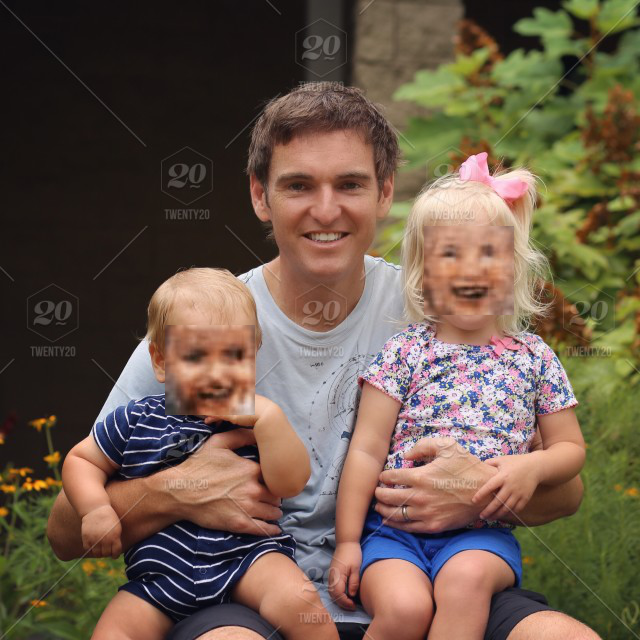

In [ ]:
# Input: image directory
image_path = '/content/test_2.jpg'
# Apply happy face recognition
nonhappy_face_dict = Happy_Face_Recognition(image_path)
fake_face_dict = Transfer_Face(nonhappy_face_dict)
Replace_Face(fake_face_dict, image_path)